# 'Train_and_test.ipynb' is for training and testing the GoogLeNet-GAP network

## Imports, constants and path
- Set the constants describing the network training process
- Download Inception_v3 network checkpoint file
- Set the path for each purpose

In [7]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import tensorflow as tf
from tensorflow.contrib import slim
slim = tf.contrib.slim

import numpy as np
import matplotlib.pyplot as plt
import math
import sys
import time
from tqdm import tqdm
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" # Set which GPU to use

import read_tfrecord
from inception_model import inception_gap

# Constants describing the training process
NUM_EPOCHS=1000
LEARNING_RATE=1e-5
WEIGHT_DECAY_TERM = 5e-4
EARLY_STOPPING_PATIENCE = 10
INPUT_DIM = (64, 64, 3)
INCEPTION_INPUT_DIM = (224, 224, 3)
OUTPUT_DIM = 200
BATCH_SIZE = 64

TRAIN_REVISED_LAYER = "TRAIN_REVISED_LAYER"
TRAIN_ENTIRE_MODEL = "TRAIN_ENTIRE_MODEL"

SAVE_MODEL_DIR=None
TRAIN_TFRECORD_PATH = "/home/hpc/github/has_practice/dataset/tfrecords/train"
VALID_TFRECORD_PATH = "/home/hpc/github/has_practice/dataset/tfrecords/valid"
TEST_TFRECORD_PATH = "/home/hpc/github/has_practice/dataset/tfrecords/test"
INCEPTION_CHECKPOINT_PATH = "/home/hpc/github/hide_and_seek/checkpoints/inception_v3/inception_v3.ckpt"

## Util functions for training and test

In [8]:
def preprocess_for_inception(image, height, width, central_fraction=False, scope=None):
    """Prepare one image for inception network.
    If height and width are specified it would output an image with that size by
    applying resize_bilinear.
    If central_fraction is specified it would crop the central fraction of the
    input image.
    Args:
    image: 3-D Tensor of image. If dtype is tf.float32 then the range should be
      [0, 1], otherwise it would converted to tf.float32 assuming that the range
      is [0, MAX], where MAX is largest positive representable number for
      int(8/16/32) data type (see `tf.image.convert_image_dtype` for details).
    height: integer
    width: integer
    central_fraction: Optional Float, fraction of the image to crop.
    scope: Optional scope for name_scope.
    Returns:
    3-D float Tensor of prepared image.
    """

    with tf.name_scope(scope, 'eval_image', [image, height, width]):
        if image.dtype != tf.float32:
            image = tf.image.convert_image_dtype(image, dtype=tf.float32)
            # Crop the central region of the image with an area containing 87.5% of
            # the original image.
        if central_fraction:
            image = tf.image.central_crop(image, central_fraction=central_fraction)
        if height and width:
            # Resize the image to the specified height and width.
            # image = tf.expand_dims(image, 0)
            image = tf.image.resize_bilinear(image, [height, width], align_corners=False)
            # image = tf.squeeze(image, [0])
        image = tf.subtract(image, 0.5)
        image = tf.multiply(image, 2.0)
    return image

def compute_metrics(sess, X, Y, data_initializer):
    """Check the accuracy of the model (depending on data_initializer).
    
    """
    
    # Initialize the input dataset
    sess.run(data_initializer)
    
    num_correct, num_samples = 0, 0
    loss_total = 0.
    while True:
        try:
            X_batch, Y_batch = sess.run([X, Y])
            correct_pred_batch, loss_batch = sess.run([g_correct_pred, g_loss],
                                                      feed_dict={g_preprocessed_X: X_batch,
                                                                 g_Y: Y_batch,
                                                                 g_is_training: False})
            num_correct += correct_pred_batch.sum()
            num_samples += correct_pred_batch.shape[0]
            loss_total += correct_pred_batch.shape[0] * loss_batch
        except tf.errors.OutOfRangeError:
            break

    acc = float(num_correct) / num_samples
    loss_total = loss_total / num_samples
    return acc, loss_total

## Define GoogLeNet-GAP network

In [ ]:
"""Define GoogLeNet-GAP network

"""
graph = tf.Graph()
with graph.as_default():   
    with tf.variable_scope('input'):
        g_X = tf.placeholder(dtype=tf.float32, shape=[None, *INPUT_DIM], name="X")
        g_preprocessed_X = preprocess_for_inception(g_X, INCEPTION_INPUT_DIM[0], INCEPTION_INPUT_DIM[1])
        g_Y = tf.placeholder(dtype=tf.float32, shape=[None, OUTPUT_DIM], name="Y")

        g_learning_rate = tf.placeholder_with_default(1e-4, shape=None, name='learning_rate')
        g_is_training = tf.placeholder_with_default(False, shape=None, name='is_training')
        g_weight_decay = tf.placeholder_with_default(0., shape=None, name="weight_decay")
        
    logits, g_Y_pred = inception_gap.inception_gap(X=g_preprocessed_X,
                                                 output_dim=OUTPUT_DIM,
                                                 input_dim=INPUT_DIM,                                                                         
                                                 is_training=g_is_training,
                                                 weight_decay=g_weight_decay)

    gap_var_list = tf.contrib.framework.get_variables('gap')
    gap_init = tf.variables_initializer(gap_var_list)
    print ('gap_var_list: ', gap_var_list)

    g_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=g_Y))
    
    gap_optimizer = tf.train.AdamOptimizer(g_learning_rate)
    full_optimizer = tf.train.AdamOptimizer(g_learning_rate)
    
    with tf.variable_scope('loss'):
        g_gap_updates = gap_optimizer.minimize(g_loss, var_list=gap_var_list)
        g_full_updates = full_optimizer.minimize(g_loss)
        g_updates_dict = {TRAIN_REVISED_LAYER: g_gap_updates, TRAIN_ENTIRE_MODEL: g_full_updates}
   
    g_correct_pred = tf.equal(tf.argmax(g_Y_pred, 1), tf.argmax(g_Y, 1))
    g_acc = tf.reduce_mean(tf.cast(g_correct_pred, tf.float64))   
    
#     variables_to_restore = tf.contrib.framework.get_variables_to_restore(include=["InceptionV3"])
#     init_fn = tf.contrib.framework.assign_from_checkpoint_fn(INCEPTION_CHECKPOINT_PATH, variables_to_restore)

    model_saver = tf.train.Saver()
    
print ("Defined the computation graph completely")

logits dimension:  [None, 200]
Y_pred dimension:  [None, 200]
gap_var_list:  [<tf.Variable 'gap/conv_second/weights:0' shape=(1, 1, 2048, 200) dtype=float32_ref>, <tf.Variable 'gap/conv_second/biases:0' shape=(200,) dtype=float32_ref>]
Defined the computation graph completely


## Train the GoogLeNet-GAP network with training and validation data

In [ ]:
"""Train the GoogLeNet-GAP network with training and validation data

"""
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(graph=graph, config=config) as sess:
    
    variables_list = graph.get_collection('variables')
    sess.run(tf.variables_initializer(variables_list))
    
#     variables_to_restore = tf.contrib.framework.get_variables_to_restore(include=["InceptionV3"])
#     init_fn = tf.contrib.framework.assign_from_checkpoint_fn(INCEPTION_CHECKPOINT_PATH, variables_to_restore)
    
#     init_fn(sess)
    model_saver.restore(sess, '/home/hpc/github/HaS_submit/tmp/Fri Mar  9 10:48:48 2018/TRAIN_REVISED_LAYER/TRAIN_REVISED_LAYER')    
    
    # Read data from tfrecord
    read_data_dict = read_tfrecord.read_tfrecord(tfrecord_train_dir=TRAIN_TFRECORD_PATH,
                                                tfrecord_valid_dir=VALID_TFRECORD_PATH,
                                                tfrecord_test_dir=TEST_TFRECORD_PATH,
                                                batch_size=BATCH_SIZE)
        
    # Train for gap layer only, and then for entire model
    
    for train_mode_name in [TRAIN_ENTIRE_MODEL]: #[TRAIN_REVISED_LAYER]:#, TRAIN_ENTIRE_MODEL]:
        
        try:
            if SAVE_MODEL_DIR:
                cur_save_model_dir = SAVE_MODEL_DIR + "/" + train_mode_name
            else:
                localtime = time.asctime(time.localtime(time.time()))
                cur_save_model_dir = "./tmp/" + localtime + "/" + train_mode_name
            print ('* Current model saving directory: ', cur_save_model_dir)
            os.makedirs(cur_save_model_dir)
        except Exception as e:
            print("* Saving model error: ", str(e))
            
        print ("*"*10 + "Start training \"" + train_mode_name + "\" mode" + "*"*10)
        current_patience = EARLY_STOPPING_PATIENCE
        lowest_loss, prev_loss = math.inf, math.inf
        highest_acc = -math.inf

        training_start_time = time.time()      
        tqdm_epoch = tqdm(range(NUM_EPOCHS))
        for i_epoch in tqdm_epoch:
            sess.run(read_data_dict['data_initializer_train'])   
            i_batch=0
            while True:
                try:
                    batch_start_time = time.time() 
                    X_batch, Y_batch = sess.run([read_data_dict['X'], read_data_dict['Y_one_hot']])

                    sess.run(g_updates_dict[train_mode_name],
                            feed_dict={g_preprocessed_X: X_batch,
                                        g_Y: Y_batch,
                                        g_learning_rate: LEARNING_RATE,
                                        g_weight_decay: WEIGHT_DECAY_TERM,
                                        g_is_training: True})
                    
                    cur_batch_time = time.time() - batch_start_time
                    tqdm_epoch.set_description("* Epoch: {}, batch: {}, times: {:0.2f} sec, progress".format(i_epoch, i_batch, cur_batch_time))
                    i_batch += 1

                except tf.errors.OutOfRangeError:
                    break

            train_acc, train_loss = compute_metrics(sess, 
                read_data_dict['X'], read_data_dict['Y_one_hot'], read_data_dict['data_initializer_train'])
            valid_acc, valid_loss = compute_metrics(sess, 
                read_data_dict['X'], read_data_dict['Y_one_hot'], read_data_dict['data_initializer_valid'])

            if valid_loss >= prev_loss: # For early stopping
                current_patience -= 1                
                if current_patience <= 0: break
            prev_loss = valid_loss
                    
            if valid_acc > highest_acc: # For the best validation accuracy                
                lowest_loss = valid_loss
                highest_acc = valid_acc                
                best_valid_path = cur_save_model_dir + "/" + train_mode_name
                best_valid_path = model_saver.save(sess, best_valid_path)                
                print("* Save current best validation model: " + best_valid_path)
                current_patience = EARLY_STOPPING_PATIENCE
                
            cur_training_time = time.strftime("%H:%M:%S", time.gmtime(time.time() - training_start_time))
            print ("┌" + "-"*10, i_epoch, " epoch is done"+"-"*10)
            print ("├ Entire training time: ", cur_training_time)
            print ("├ Training accuracy: ", train_acc, "loss: ", train_loss)
            print ("├ Validation accuracy: ", valid_acc, "loss: ", valid_loss)
            print ("├ Best validation accuracy: ", highest_acc, "loss: ", lowest_loss)
            print ("└" + "-"*40)
        
        entire_training_time = time.strftime("%H:%M:%S", time.gmtime(time.time() - training_start_time))
        print ("┌" + "-"*10 + "Training is done" + "-"*10)
        print ("├ Entire training time: ", entire_training_time)
        print ("├ Best validation accuracy: ", highest_acc, "loss: ", lowest_loss)
        print ("├ Best validation path: ", best_valid_path)
        print ("└" + "-"*40)


INFO:tensorflow:Restoring parameters from /home/hpc/github/HaS_submit/tmp/Fri Mar  9 10:48:48 2018/TRAIN_REVISED_LAYER/TRAIN_REVISED_LAYER



  0%|          | 0/1000 [00:00<?, ?it/s]

* Current model saving directory:  ./tmp/Sat Mar 10 09:59:28 2018/TRAIN_ENTIRE_MODEL
**********Start training "TRAIN_ENTIRE_MODEL" mode**********



* Epoch: 0, batch: 0, times: 5.42 sec, progress:   0%|          | 0/1000 [00:05<?, ?it/s]
* Epoch: 0, batch: 1, times: 0.57 sec, progress:   0%|          | 0/1000 [00:06<?, ?it/s]
* Epoch: 0, batch: 2, times: 0.60 sec, progress:   0%|          | 0/1000 [00:06<?, ?it/s]
* Epoch: 0, batch: 3, times: 0.58 sec, progress:   0%|          | 0/1000 [00:07<?, ?it/s]
* Epoch: 0, batch: 4, times: 0.58 sec, progress:   0%|          | 0/1000 [00:08<?, ?it/s]
Exception in thread Thread-4:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/hpc/tensorflow/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/hpc/tensorflow/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

* Epoch: 0, batch: 1093, times: 1.06 sec, progress:   0%|          | 1/1000 [17:33<292:14:34, 1053.13

* Save current best validation model: ./tmp/Sat Mar 10 09:59:28 2018/TRAIN_ENTIRE_MODEL/TRAIN_ENTIRE_MODEL
┌---------- 0  epoch is done----------
├ Entire training time:  00:17:33
├ Training accuracy:  0.6372428571428571 loss:  1.66267603758
├ Validation accuracy:  0.6073333333333333 loss:  1.8758553697
├ Best validation accuracy:  0.6073333333333333 loss:  1.8758553697
└----------------------------------------


* Epoch: 1, batch: 1093, times: 0.44 sec, progress:   0%|          | 2/1000 [35:06<292:02:09, 1053.44s/it]

* Save current best validation model: ./tmp/Sat Mar 10 09:59:28 2018/TRAIN_ENTIRE_MODEL/TRAIN_ENTIRE_MODEL
┌---------- 1  epoch is done----------
├ Entire training time:  00:35:06
├ Training accuracy:  0.6651571428571429 loss:  1.51371289305
├ Validation accuracy:  0.6226333333333334 loss:  1.8124961923
├ Best validation accuracy:  0.6226333333333334 loss:  1.8124961923
└----------------------------------------


* Epoch: 2, batch: 1093, times: 0.45 sec, progress:   0%|          | 3/1000 [52:42<291:57:04, 1054.19s/it]

┌---------- 2  epoch is done----------
├ Entire training time:  00:52:42
├ Training accuracy:  0.6708857142857143 loss:  1.49904544953
├ Validation accuracy:  0.6217666666666667 loss:  1.87021795133
├ Best validation accuracy:  0.6226333333333334 loss:  1.8124961923
└----------------------------------------


* Epoch: 3, batch: 1093, times: 0.45 sec, progress:   0%|          | 4/1000 [1:10:16<291:36:43, 1054.02s/it]

┌---------- 3  epoch is done----------
├ Entire training time:  01:10:16
├ Training accuracy:  0.6734571428571429 loss:  1.51183162027
├ Validation accuracy:  0.6172 loss:  1.94783131711
├ Best validation accuracy:  0.6226333333333334 loss:  1.8124961923
└----------------------------------------


* Epoch: 4, batch: 1093, times: 0.44 sec, progress:   0%|          | 5/1000 [1:27:52<291:25:45, 1054.42s/it]

* Save current best validation model: ./tmp/Sat Mar 10 09:59:28 2018/TRAIN_ENTIRE_MODEL/TRAIN_ENTIRE_MODEL
┌---------- 4  epoch is done----------
├ Entire training time:  01:27:52
├ Training accuracy:  0.6943428571428572 loss:  1.37879562389
├ Validation accuracy:  0.6277 loss:  1.88241614723
├ Best validation accuracy:  0.6277 loss:  1.88241614723
└----------------------------------------


* Epoch: 5, batch: 1093, times: 0.45 sec, progress:   1%|          | 6/1000 [1:45:27<291:09:53, 1054.52s/it]

┌---------- 5  epoch is done----------
├ Entire training time:  01:45:27
├ Training accuracy:  0.6814714285714286 loss:  1.51158672213
├ Validation accuracy:  0.6154666666666667 loss:  2.04926089331
├ Best validation accuracy:  0.6277 loss:  1.88241614723
└----------------------------------------


* Epoch: 6, batch: 1093, times: 0.44 sec, progress:   1%|          | 7/1000 [2:03:00<290:49:04, 1054.32s/it]

┌---------- 6  epoch is done----------
├ Entire training time:  02:03:00
├ Training accuracy:  0.7026714285714286 loss:  1.37347057244
├ Validation accuracy:  0.6266 loss:  1.96321769581
├ Best validation accuracy:  0.6277 loss:  1.88241614723
└----------------------------------------


* Epoch: 7, batch: 1093, times: 0.44 sec, progress:   1%|          | 8/1000 [2:20:34<290:32:00, 1054.35s/it]

┌---------- 7  epoch is done----------
├ Entire training time:  02:20:34
├ Training accuracy:  0.6933857142857143 loss:  1.45137660146
├ Validation accuracy:  0.6174 loss:  2.06555876656
├ Best validation accuracy:  0.6277 loss:  1.88241614723
└----------------------------------------


* Epoch: 8, batch: 1093, times: 0.45 sec, progress:   1%|          | 9/1000 [2:38:11<290:17:49, 1054.56s/it]

┌---------- 8  epoch is done----------
├ Entire training time:  02:38:11
├ Training accuracy:  0.7071142857142857 loss:  1.35708101065
├ Validation accuracy:  0.6248333333333334 loss:  1.99784276479
├ Best validation accuracy:  0.6277 loss:  1.88241614723
└----------------------------------------


* Epoch: 9, batch: 1093, times: 0.45 sec, progress:   1%|          | 10/1000 [2:55:49<290:06:32, 1054.94s/it]

* Save current best validation model: ./tmp/Sat Mar 10 09:59:28 2018/TRAIN_ENTIRE_MODEL/TRAIN_ENTIRE_MODEL
┌---------- 9  epoch is done----------
├ Entire training time:  02:55:49
├ Training accuracy:  0.7160571428571428 loss:  1.32188780741
├ Validation accuracy:  0.6306333333333334 loss:  2.00233065109
├ Best validation accuracy:  0.6306333333333334 loss:  2.00233065109
└----------------------------------------


* Epoch: 10, batch: 1093, times: 0.45 sec, progress:   1%|          | 11/1000 [3:13:24<289:49:48, 1054.99s/it]

* Save current best validation model: ./tmp/Sat Mar 10 09:59:28 2018/TRAIN_ENTIRE_MODEL/TRAIN_ENTIRE_MODEL
┌---------- 10  epoch is done----------
├ Entire training time:  03:13:24
├ Training accuracy:  0.7234285714285714 loss:  1.28943738845
├ Validation accuracy:  0.6335666666666666 loss:  1.99966176809
├ Best validation accuracy:  0.6335666666666666 loss:  1.99966176809
└----------------------------------------


* Epoch: 11, batch: 1093, times: 0.46 sec, progress:   1%|          | 12/1000 [3:31:06<289:41:25, 1055.55s/it]

* Save current best validation model: ./tmp/Sat Mar 10 09:59:28 2018/TRAIN_ENTIRE_MODEL/TRAIN_ENTIRE_MODEL
┌---------- 11  epoch is done----------
├ Entire training time:  03:31:06
├ Training accuracy:  0.7261428571428571 loss:  1.28575538039
├ Validation accuracy:  0.6346 loss:  2.03171171239
├ Best validation accuracy:  0.6346 loss:  2.03171171239
└----------------------------------------


* Epoch: 12, batch: 1093, times: 0.46 sec, progress:   1%|▏         | 13/1000 [3:48:55<289:40:40, 1056.58s/it]

┌---------- 12  epoch is done----------
├ Entire training time:  03:48:55
├ Training accuracy:  0.7266571428571429 loss:  1.3072235521
├ Validation accuracy:  0.6340333333333333 loss:  2.07608144213
├ Best validation accuracy:  0.6346 loss:  2.03171171239
└----------------------------------------


* Epoch: 13, batch: 1093, times: 0.47 sec, progress:   1%|▏         | 14/1000 [4:06:39<289:32:12, 1057.13s/it]

┌---------- 13  epoch is done----------
├ Entire training time:  04:06:39
├ Training accuracy:  0.716 loss:  1.36669007647
├ Validation accuracy:  0.6222333333333333 loss:  2.14007469699
├ Best validation accuracy:  0.6346 loss:  2.03171171239
└----------------------------------------


* Epoch: 14, batch: 1093, times: 0.45 sec, progress:   2%|▏         | 15/1000 [4:24:22<289:20:28, 1057.49s/it]

┌---------- 14  epoch is done----------
├ Entire training time:  04:24:22
├ Training accuracy:  0.7160714285714286 loss:  1.39611368479
├ Validation accuracy:  0.6212666666666666 loss:  2.19245897268
├ Best validation accuracy:  0.6346 loss:  2.03171171239
└----------------------------------------


* Epoch: 15, batch: 1093, times: 0.45 sec, progress:   2%|▏         | 16/1000 [4:42:30<289:34:30, 1059.42s/it]

┌---------- 15  epoch is done----------
├ Entire training time:  04:42:30
├ Training accuracy:  0.7304285714285714 loss:  1.29862142026
├ Validation accuracy:  0.6319666666666667 loss:  2.11702949988
├ Best validation accuracy:  0.6346 loss:  2.03171171239
└----------------------------------------


* Epoch: 16, batch: 1093, times: 0.46 sec, progress:   2%|▏         | 17/1000 [5:00:02<289:09:24, 1058.97s/it]

┌---------- 16  epoch is done----------
├ Entire training time:  05:00:02
├ Training accuracy:  0.7148571428571429 loss:  1.41731574399
├ Validation accuracy:  0.6162666666666666 loss:  2.24989931107
├ Best validation accuracy:  0.6346 loss:  2.03171171239
└----------------------------------------


* Epoch: 17, batch: 1093, times: 0.45 sec, progress:   2%|▏         | 17/1000 [5:10:47<299:31:09, 1096.92s/it]

## Test classification accuracy of the trained model with test data

In [3]:
"""Test the trained model with test data

"""
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(graph=graph, config=config) as sess:
    model_saver.restore(sess, '/home/hpc/github/has_practice/tmp/20180305_130718_WDTV0M/TRAIN_REVISED_LAYER/TRAIN_REVISED_LAYER')

    # Read data from tfrecord
    read_data_dict = read_tfrecord.read_tfrecord(tfrecord_train_dir=TRAIN_TFRECORD_PATH,
                                                tfrecord_valid_dir=VALID_TFRECORD_PATH,
                                                tfrecord_test_dir=TEST_TFRECORD_PATH,
                                                batch_size=BATCH_SIZE)
    test_acc, test_loss = compute_metrics(sess, read_data_dict['X'], read_data_dict['Y_one_hot'], read_data_dict['data_initializer_test'])
    print("* Test accuracy: " + test_acc + "loss: " + test_loss)


## Check dataset and visualize

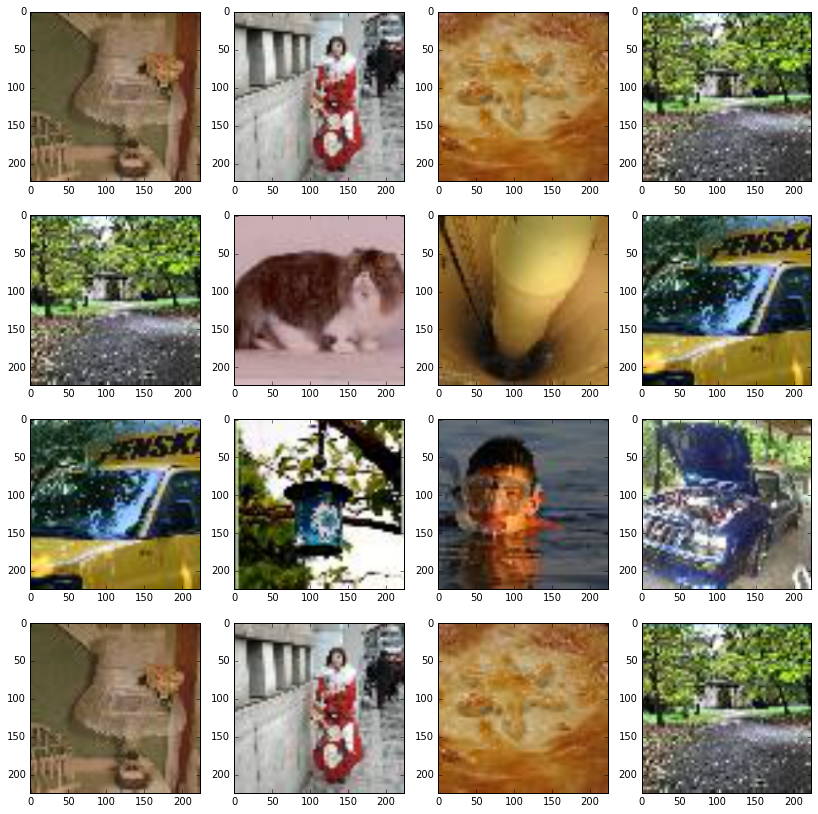

In [6]:
""" Check dataset (train, validation, test)   

"""
g = tf.Graph()
with g.as_default():
    read_data_dict = read_tfrecord.read_tfrecord(tfrecord_train_dir=TRAIN_TFRECORD_PATH,
                                                tfrecord_valid_dir=VALID_TFRECORD_PATH,
                                                tfrecord_test_dir=TEST_TFRECORD_PATH,
                                                batch_size=BATCH_SIZE)
   
    sess = tf.Session()
    sess.run(read_data_dict['data_initializer_train'])
    X_raw = sess.run(read_data_dict['X'])
    X_restored = X_raw * 0.5
    X_restored += 0.5
    X_restored = X_restored * 255
    X_restored = X_restored.astype(np.uint8)
    fig, axes = plt.subplots(4, 4, figsize=(14,14))
    for y in range(4):
        for x in range(4):
            axes[y][x].imshow(X_restored[x+(y%3)*3])